Homework: За healthcare-dataset-stroke-data.csv:
1.Направете EDA (single и bivariate) анализа.
 Направете чистење и пополнување на NAN values (кај BMI најбитно)
2.Направете класификација на target променливата: stroke
3.Забелешка: не е балансиран dataset-от. 
4.Бонус: употребете SMOTE за да го избалансирате.
Vasil Stamenkoski


In [1]:
import os
import random
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras import layers
from keras.models import Sequential
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

RANDOM_STATE = 42

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.drop(columns=['id'], inplace=True)

In [3]:
df 

gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1     Female  61.0             0              0          Yes  Self-employed   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
5105  Female  80.0             1              0          Yes        Private   
5106  Female  81.0             0              0          Yes  Self-employed   
5107  Female  35.0             0              0          Yes  Self-employed   
5108    Male  51.0             0              0          Yes        Private   
5109  Female  44.0             0              0          Yes       Govt_job   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0             Urban             228.69  36.6  formerly smoked       1  
1             Rural             202.21   NaN     never smoked       1  
2             Rural             105.92  32.5     never smoked       1  
3             Urban             171.23  34.4           smokes       1  
4             Rural             174.12  24.0     never smoked       1  
...             ...                ...   ...              ...     ...  
5105          Urban              83.75   NaN     never smoked       0  
5106          Urban             125.20  40.0     never smoked       0  
5107          Rural              82.99  30.6     never smoked       0  
5108          Rural             166.29  25.6  formerly smoked       0  
5109          Urban              85.28  26.2          Unknown       0  

[5110 rows x 11 columns]

In [4]:
df.shape[0]

5110

In [5]:
df.shape[1]

11

In [6]:
print(f'{df.shape[0]} & {df.shape[1]}')

5110 & 11


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [8]:
df.describe()

age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  4909.000000  5110.000000  
mean     28.893237     0.048728  
std       7.854067     0.215320  
min      10.300000     0.000000  
25%      23.500000     0.000000  
50%      28.100000     0.000000  
75%      33.100000     0.000000  
max      97.600000     1.000000

In [9]:
#dispaly stats fro categorical features

df.describe(exclude=['float', 'int64'])

gender ever_married work_type Residence_type smoking_status
count     5110         5110      5110           5110           5110
unique       3            2         5              2              4
top     Female          Yes   Private          Urban   never smoked
freq      2994         3353      2925           2596           1892

In [10]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [11]:
#null values for each col

df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [12]:
#percent of people with stroke

pps = df['stroke'].sum() / len(df) 
print('Patients with stroke in this dataset {:.2f}% '.format(pps*100))

Patients with stroke in this dataset 4.87% 


In [13]:
def missing(df):
    missing_num = df.isnull().sum().sort_values(ascending=False)
    missing_percent = df.isnull().sum() / df.isnull().count().sort_values(ascending=False)
    missing_values = pd.concat([missing_num, missing_percent], axis=1, keys=['Missing Number', 'Missing Percent'])
    
    return missing_values

missing(df)

Missing Number  Missing Percent
bmi                           201         0.039335
gender                          0         0.000000
age                             0         0.000000
hypertension                    0         0.000000
heart_disease                   0         0.000000
ever_married                    0         0.000000
work_type                       0         0.000000
Residence_type                  0         0.000000
avg_glucose_level               0         0.000000
smoking_status                  0         0.000000
stroke                          0         0.000000

In [14]:
categorical_cols = []
numerical_cols = []

for col in df.columns:
    if df[col].dtype == 'object':
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

print("Categorical columns: ", categorical_cols)
print("Numerical columns: ", numerical_cols)

Categorical columns:  ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Numerical columns:  ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']


In [15]:
def categorical_to_numeric(df):
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    cat_maps = {col: {cat: i for i, cat in enumerate(df[col].unique())} for col in cat_cols}
    for col, cat_map in cat_maps.items():
        df[col] = df[col].map(cat_map)
    
    return df

In [16]:
df = categorical_to_numeric(df)

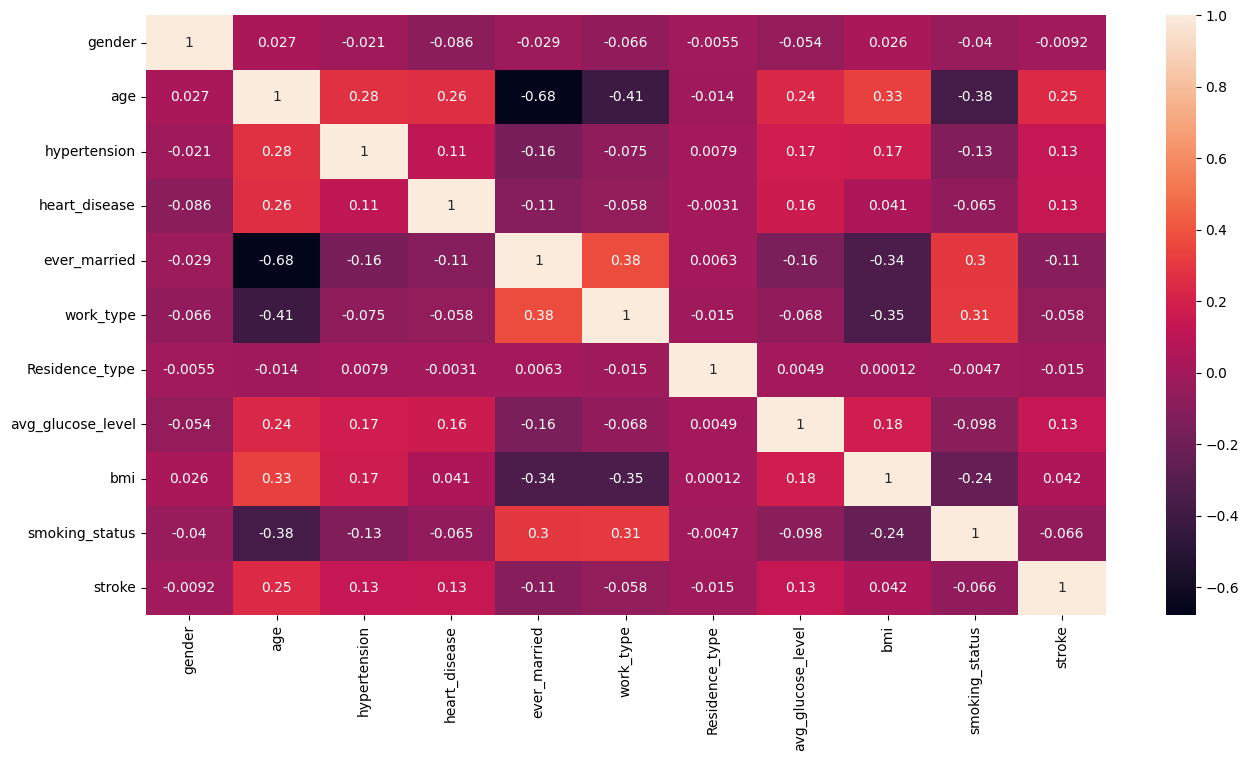

In [17]:
fig,axs = plt.subplots(nrows=1, ncols=1, figsize= (15, 6))
plt.subplots_adjust(left=0.1, bottom=0.1,right=0.9,top=1.1,wspace=0.4, hspace=0.4)

pearson_correlation = (df.corr(method='pearson',numeric_only=True))

sns.heatmap(pearson_correlation,annot=True)

plt.show()

In [18]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [20]:
#filling,scaling,splitting,SMOTE
X = df.drop(columns=['stroke'])
y = df['stroke']

imputer = KNNImputer(n_neighbors=5)
X_imputed = X.copy()
X_imputed['bmi'] = imputer.fit_transform(X[['bmi']])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print('Number of training samples before:', len(X_train))
print('Number of training samples after:', len(X_train_resampled))

Number of training samples before: 3066
Number of training samples after: 5846


In [21]:
X_imputed.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

In [22]:
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski',algorithm='auto',n_jobs=None)
knn_model.fit(X_train_resampled,y_train_resampled)

KNeighborsClassifier()

In [23]:
y_pred = knn_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       960
           1       0.14      0.42      0.21        62

    accuracy                           0.81      1022
   macro avg       0.55      0.63      0.55      1022
weighted avg       0.91      0.81      0.85      1022



In [25]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train_resampled,y_train_resampled)

In [26]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.70      0.82       960
           1       0.14      0.79      0.24        62

    accuracy                           0.70      1022
   macro avg       0.56      0.74      0.53      1022
weighted avg       0.93      0.70      0.78      1022



In [27]:
lr_model = LogisticRegression(max_iter=100,solver='lbfgs',C=1)
lr_model = lr_model.fit(X_train_resampled,y_train_resampled)

In [28]:
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      0.76      0.86       960
           1       0.17      0.76      0.28        62

    accuracy                           0.76      1022
   macro avg       0.58      0.76      0.57      1022
weighted avg       0.93      0.76      0.82      1022



In [29]:
##Plotting

def plot_history(history):
    fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'],label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentropy')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history.history['accuracy'],label='accuracy')
    ax2.plot(history.history['val_accuracy'],label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    plt.show()


In [30]:
def train_model(X_train_resampled, y_train_resampled, num_nodes, dropout_prob, learning_rate, batch_size, epochs):
    
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes, activation='relu',input_shape=(10,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='sigmoid')
     ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),loss='binary_crossentropy',metrics=['accuracy'])
    history = nn_model.fit(X_train_resampled, y_train_resampled, epochs=epochs,batch_size=batch_size,validation_split=0.2,verbose=0)

    return nn_model, history

16 nodes, dropout 0, learning rate0.005, batch size32


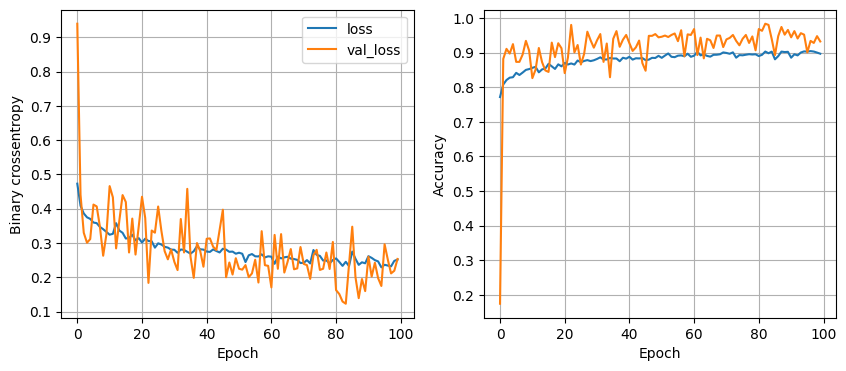

128/128 [==============================] - 0s 1ms/step - loss: 0.1935 - accuracy: 0.9129
16 nodes, dropout 0, learning rate0.005, batch size64


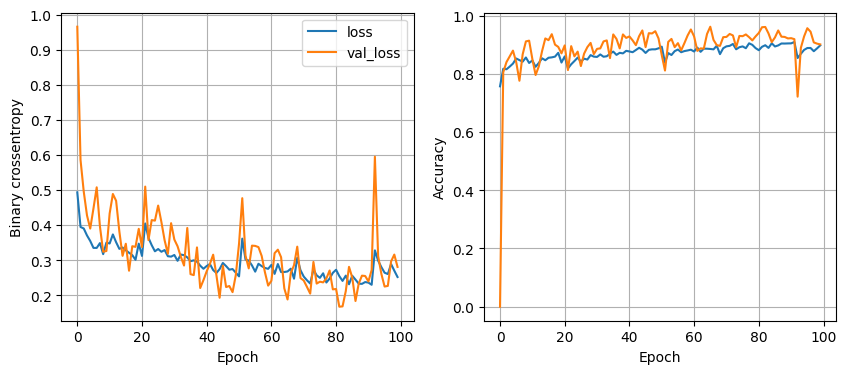

128/128 [==============================] - 0s 1ms/step - loss: 0.2392 - accuracy: 0.8929
16 nodes, dropout 0, learning rate0.005, batch size128


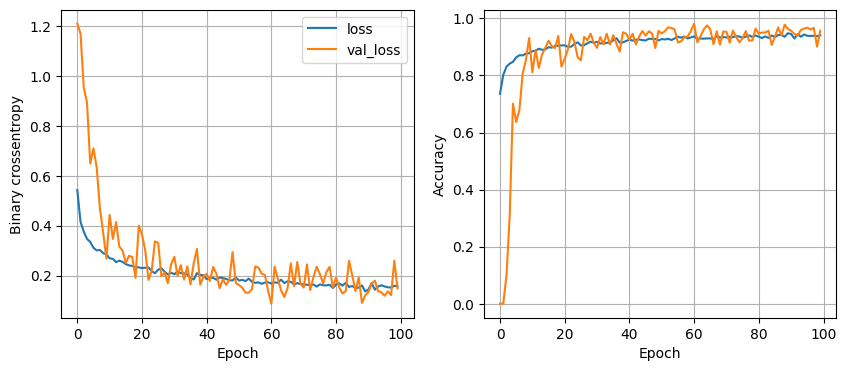

128/128 [==============================] - 0s 1ms/step - loss: 0.1855 - accuracy: 0.9337
16 nodes, dropout 0, learning rate0.001, batch size32


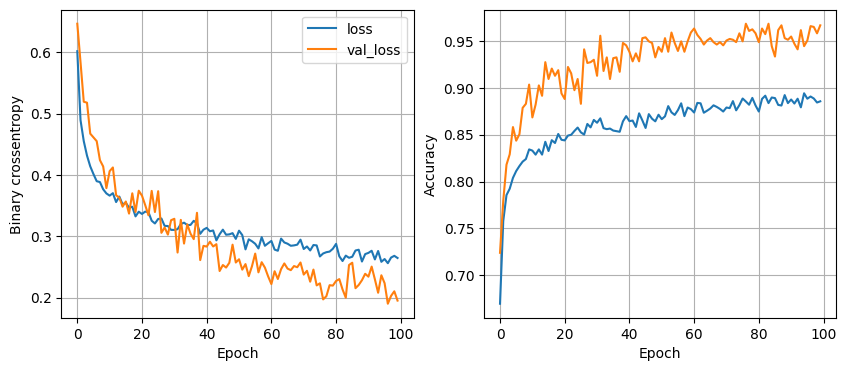

128/128 [==============================] - 0s 1ms/step - loss: 0.2424 - accuracy: 0.8828
16 nodes, dropout 0, learning rate0.001, batch size64


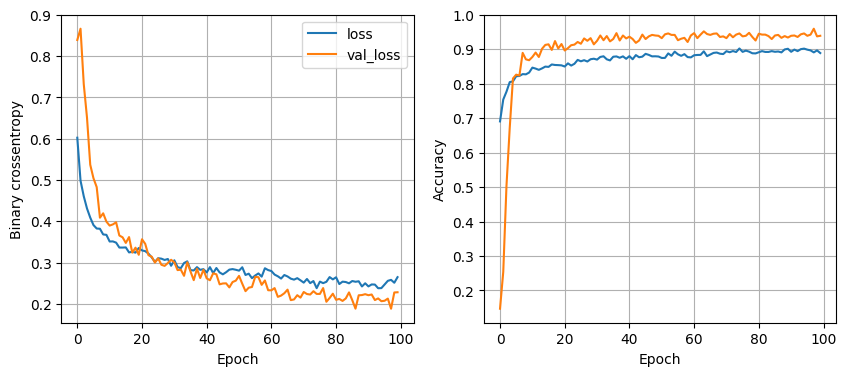

128/128 [==============================] - 0s 1ms/step - loss: 0.2297 - accuracy: 0.8943
16 nodes, dropout 0, learning rate0.001, batch size128


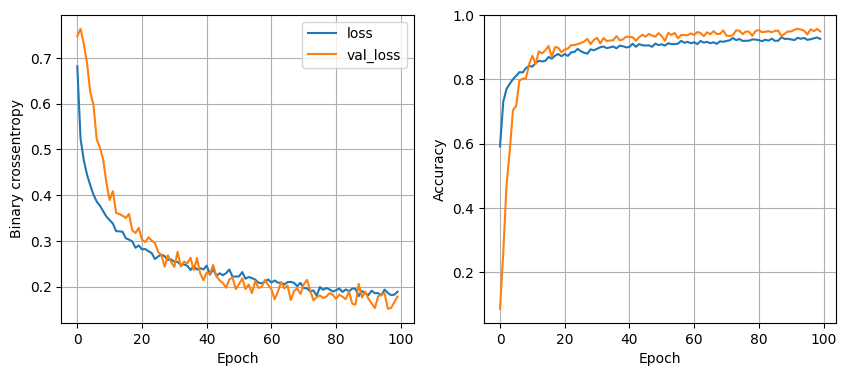

128/128 [==============================] - 0s 1ms/step - loss: 0.1939 - accuracy: 0.9281
16 nodes, dropout 0, learning rate0.01, batch size32


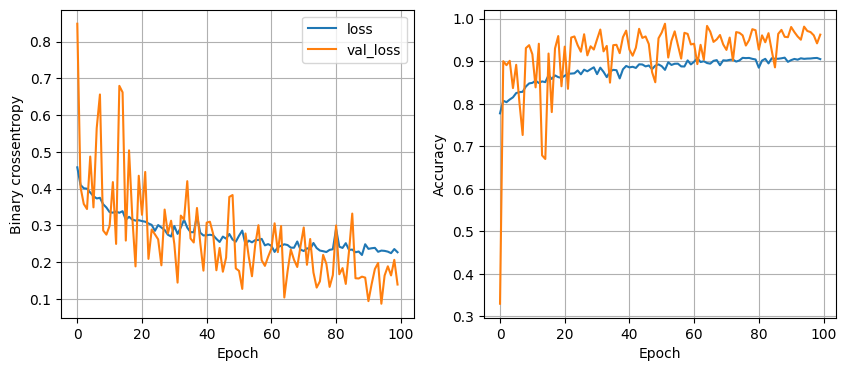

128/128 [==============================] - 0s 1ms/step - loss: 0.2463 - accuracy: 0.8951
16 nodes, dropout 0, learning rate0.01, batch size64


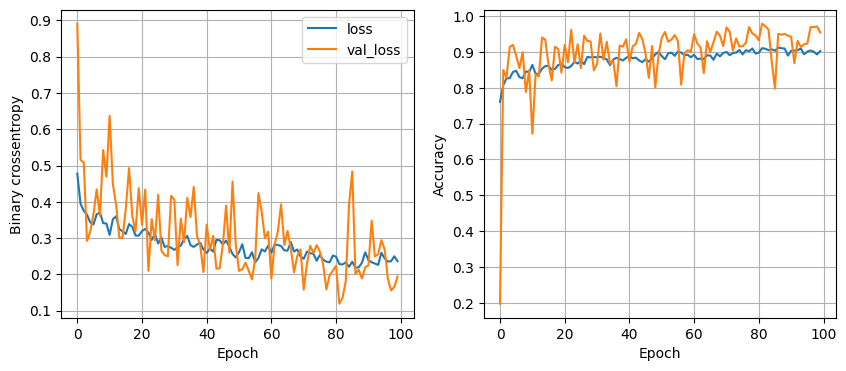

128/128 [==============================] - 0s 1ms/step - loss: 0.2365 - accuracy: 0.8980
16 nodes, dropout 0, learning rate0.01, batch size128


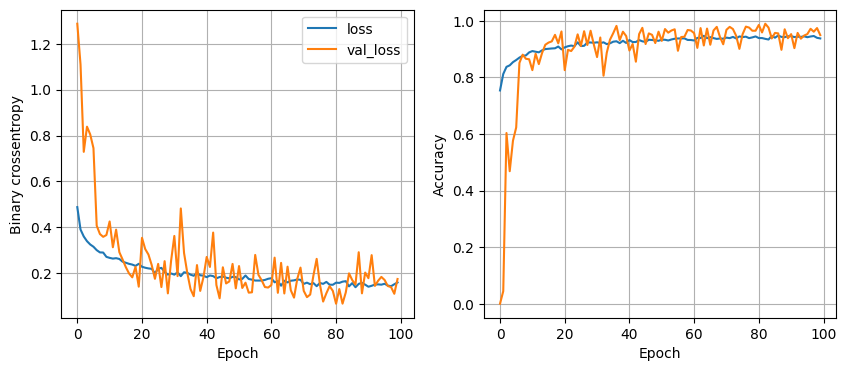

128/128 [==============================] - 0s 1ms/step - loss: 0.1904 - accuracy: 0.9347
16 nodes, dropout 0.2, learning rate0.005, batch size32


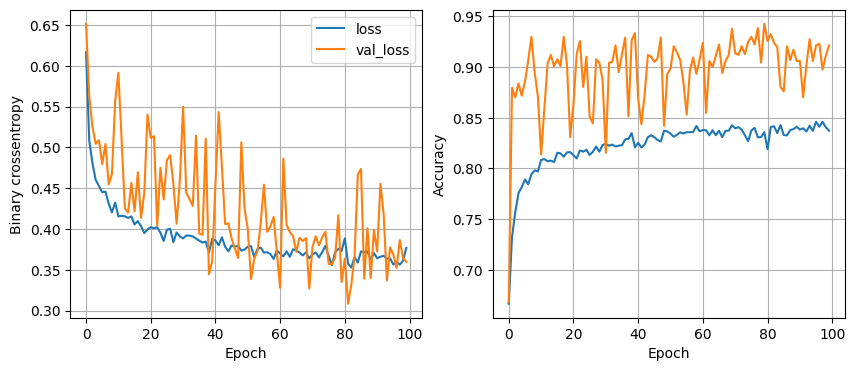

128/128 [==============================] - 0s 1ms/step - loss: 0.2999 - accuracy: 0.8378
16 nodes, dropout 0.2, learning rate0.005, batch size64


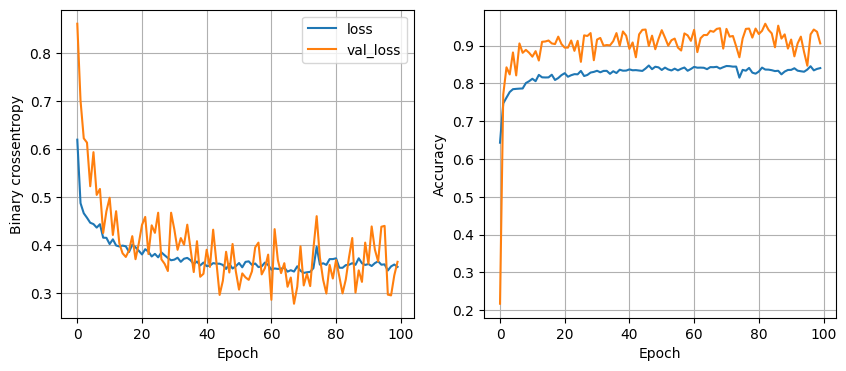

128/128 [==============================] - 0s 1ms/step - loss: 0.2889 - accuracy: 0.8449
16 nodes, dropout 0.2, learning rate0.005, batch size128


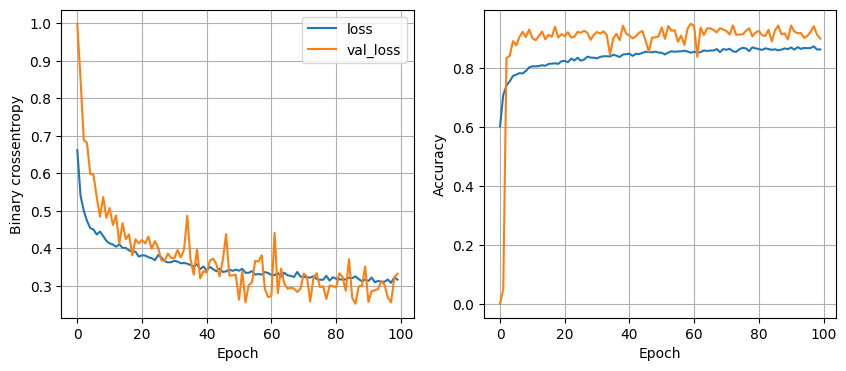

128/128 [==============================] - 0s 1ms/step - loss: 0.2625 - accuracy: 0.8738
16 nodes, dropout 0.2, learning rate0.001, batch size32


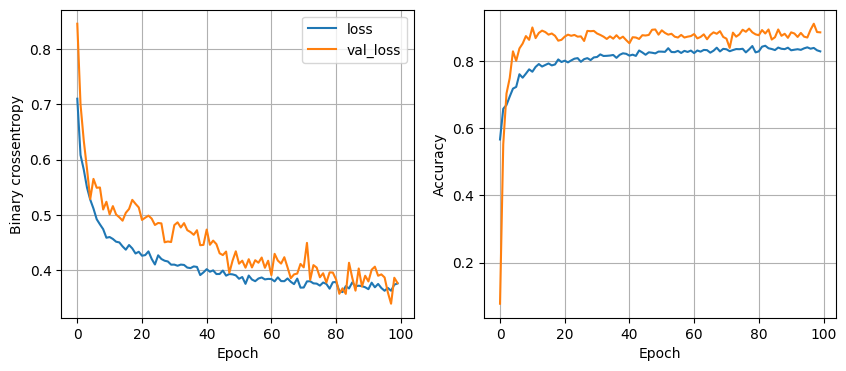

128/128 [==============================] - 0s 1ms/step - loss: 0.2983 - accuracy: 0.8469
16 nodes, dropout 0.2, learning rate0.001, batch size64


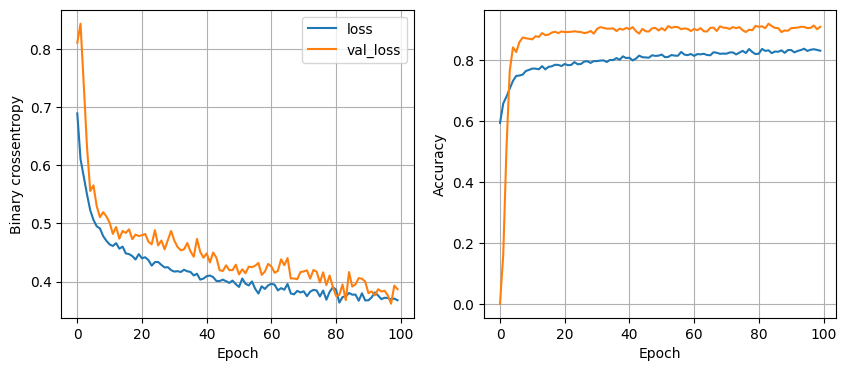

128/128 [==============================] - 0s 1ms/step - loss: 0.3033 - accuracy: 0.8227
16 nodes, dropout 0.2, learning rate0.001, batch size128


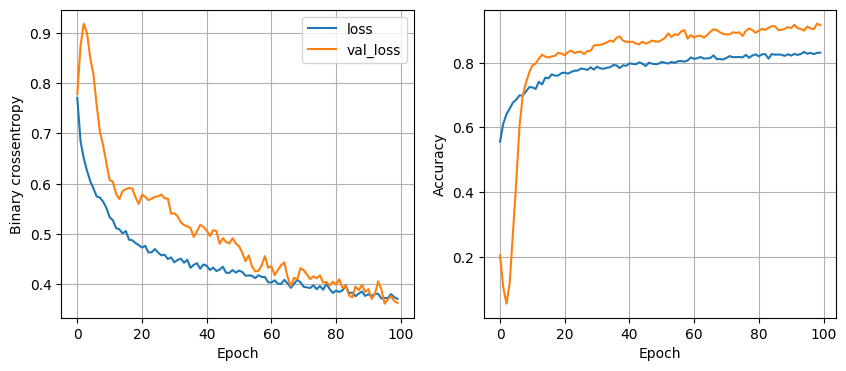

128/128 [==============================] - 0s 1ms/step - loss: 0.3215 - accuracy: 0.8058
16 nodes, dropout 0.2, learning rate0.01, batch size32


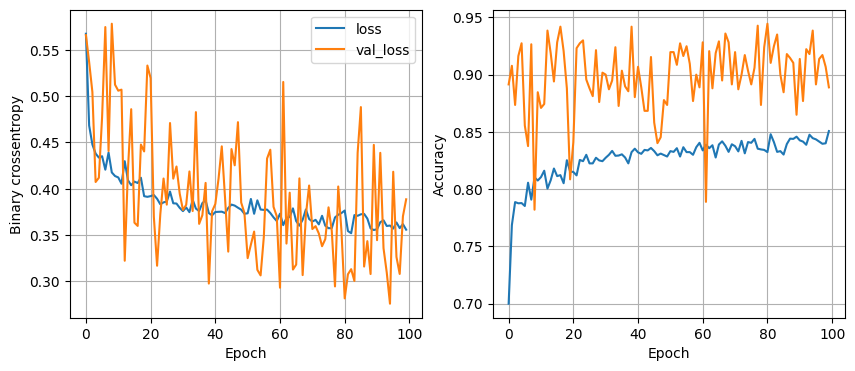

128/128 [==============================] - 0s 1ms/step - loss: 0.2644 - accuracy: 0.8657
16 nodes, dropout 0.2, learning rate0.01, batch size64


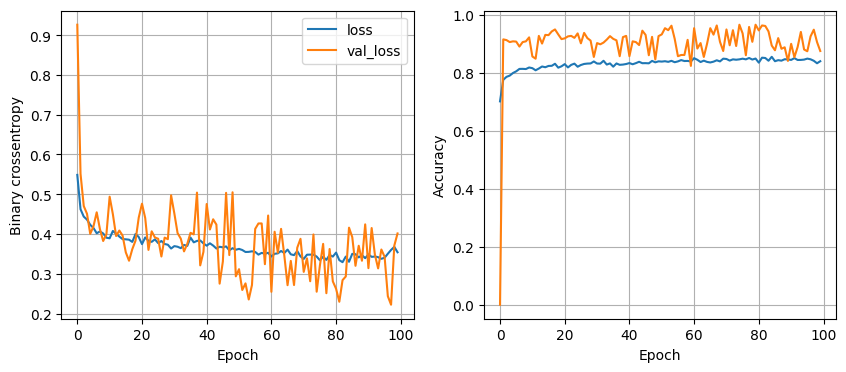

128/128 [==============================] - 0s 1ms/step - loss: 0.2939 - accuracy: 0.8474
16 nodes, dropout 0.2, learning rate0.01, batch size128


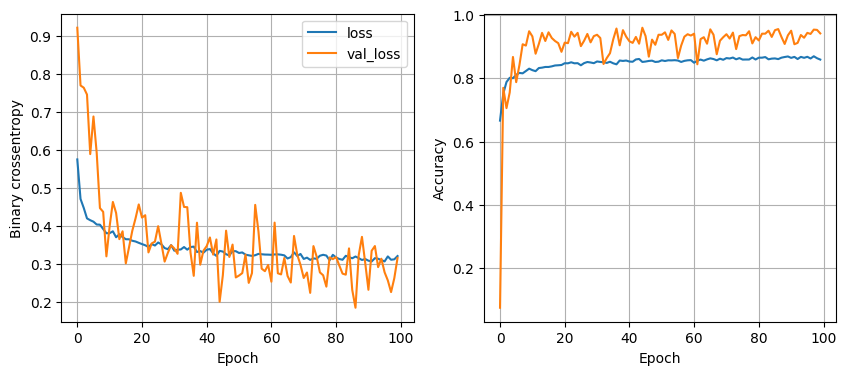

128/128 [==============================] - 0s 1ms/step - loss: 0.2645 - accuracy: 0.8567
32 nodes, dropout 0, learning rate0.005, batch size32


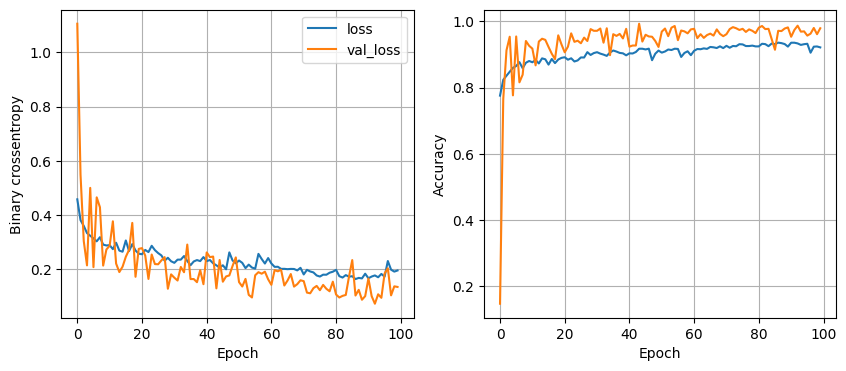

128/128 [==============================] - 0s 1ms/step - loss: 0.2098 - accuracy: 0.9141
32 nodes, dropout 0, learning rate0.005, batch size64


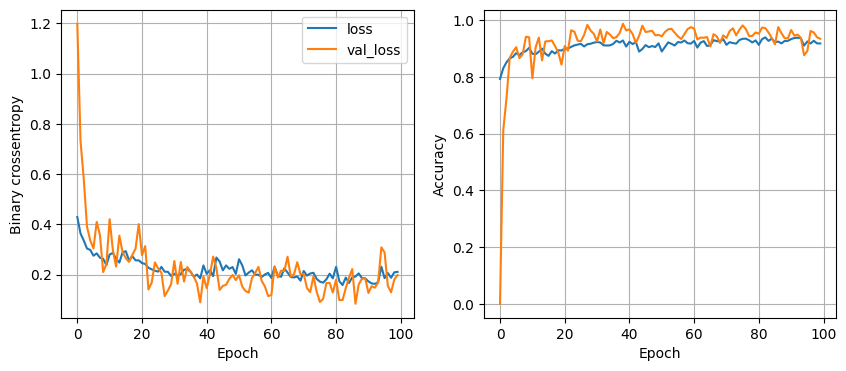

128/128 [==============================] - 0s 1ms/step - loss: 0.2129 - accuracy: 0.9166
32 nodes, dropout 0, learning rate0.005, batch size128


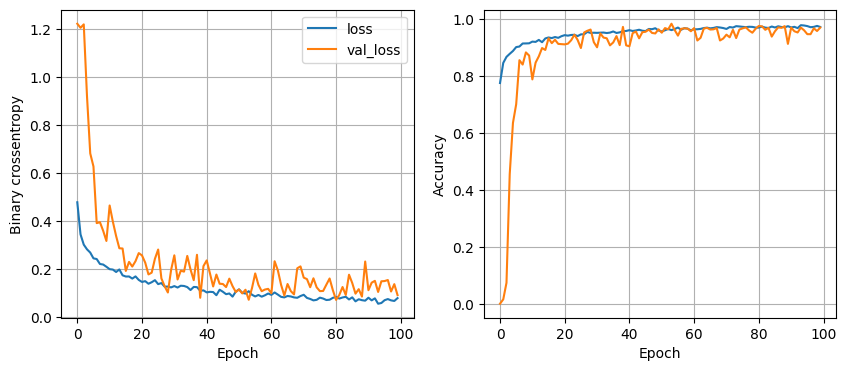

128/128 [==============================] - 0s 1ms/step - loss: 0.1776 - accuracy: 0.9606
32 nodes, dropout 0, learning rate0.001, batch size32


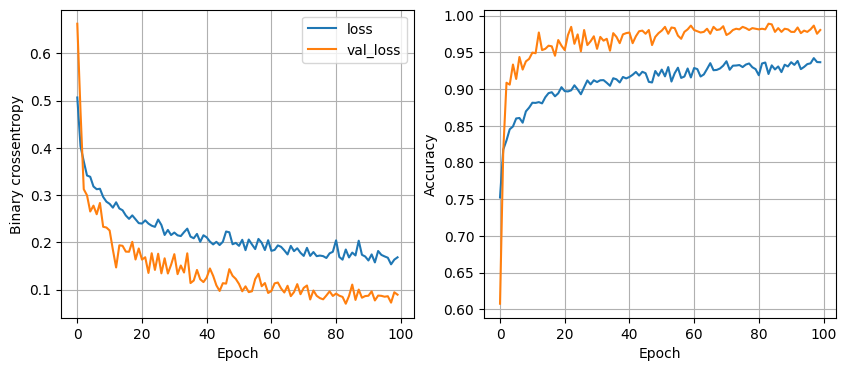

128/128 [==============================] - 0s 1ms/step - loss: 0.1860 - accuracy: 0.9357
32 nodes, dropout 0, learning rate0.001, batch size64


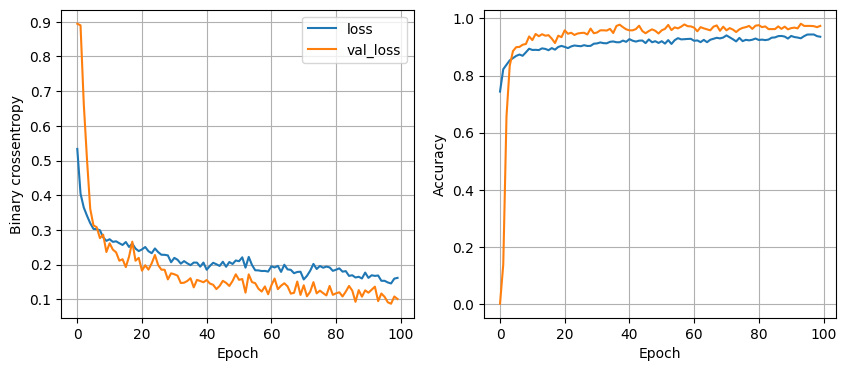

128/128 [==============================] - 0s 1ms/step - loss: 0.1868 - accuracy: 0.9322
32 nodes, dropout 0, learning rate0.001, batch size128


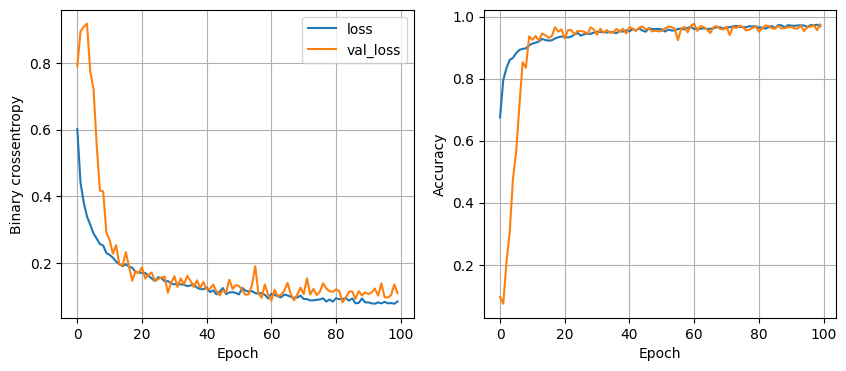

128/128 [==============================] - 0s 1ms/step - loss: 0.1491 - accuracy: 0.9626
32 nodes, dropout 0, learning rate0.01, batch size32


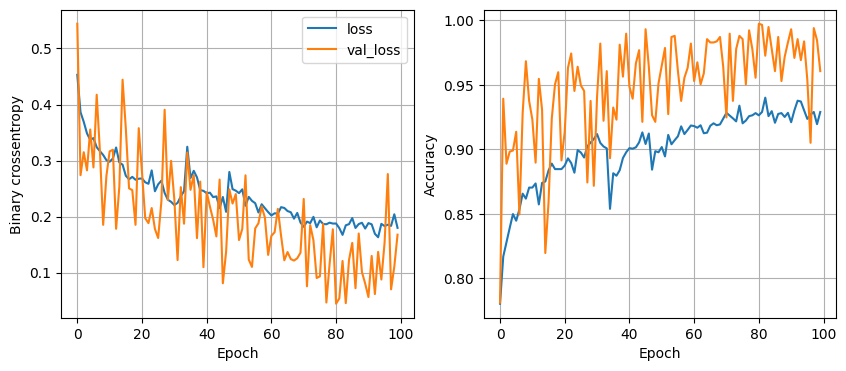

128/128 [==============================] - 0s 1ms/step - loss: 0.2252 - accuracy: 0.9318
32 nodes, dropout 0, learning rate0.01, batch size64


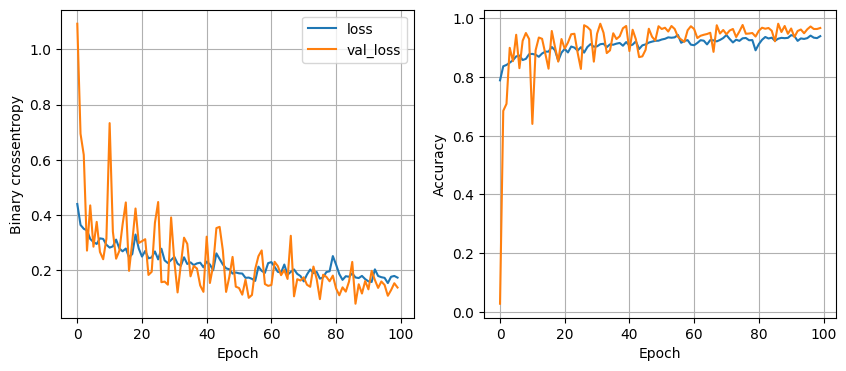

128/128 [==============================] - 0s 1ms/step - loss: 0.1765 - accuracy: 0.9349
32 nodes, dropout 0, learning rate0.01, batch size128


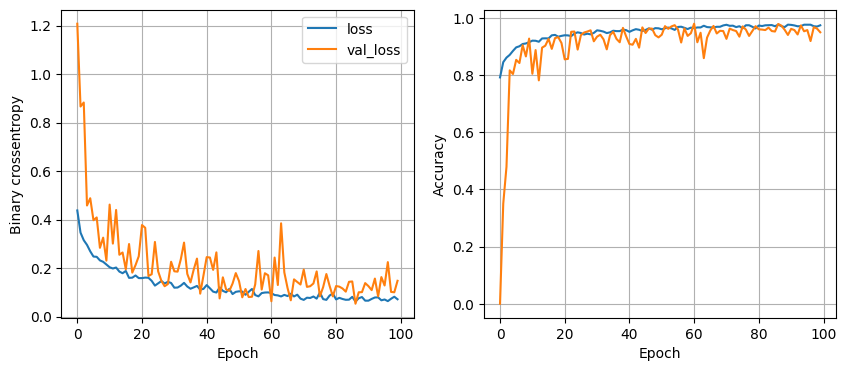

128/128 [==============================] - 0s 1ms/step - loss: 0.1478 - accuracy: 0.9677
32 nodes, dropout 0.2, learning rate0.005, batch size32


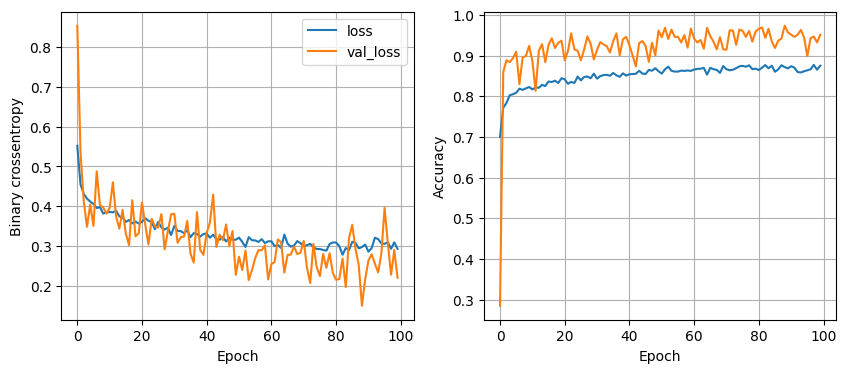

128/128 [==============================] - 0s 1ms/step - loss: 0.2654 - accuracy: 0.8628
32 nodes, dropout 0.2, learning rate0.005, batch size64


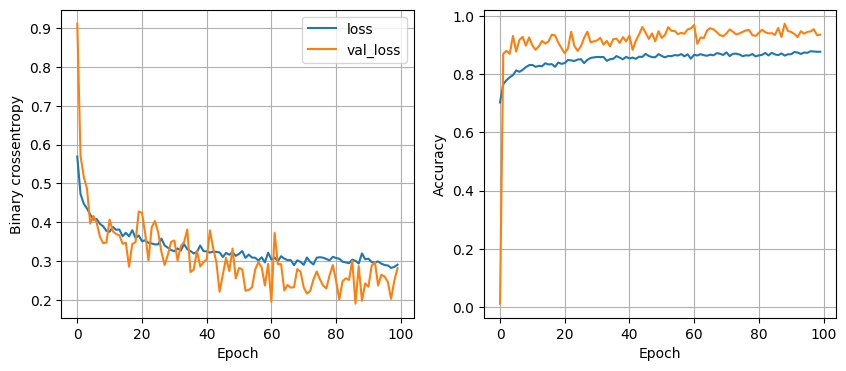

128/128 [==============================] - 0s 1ms/step - loss: 0.2179 - accuracy: 0.8889
32 nodes, dropout 0.2, learning rate0.005, batch size128


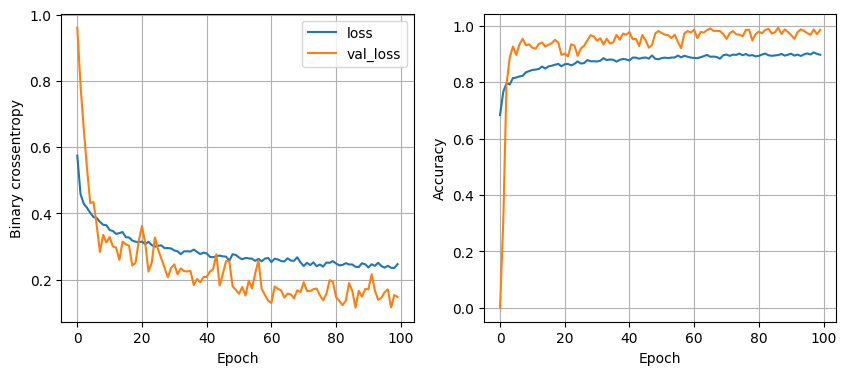

128/128 [==============================] - 0s 1ms/step - loss: 0.2365 - accuracy: 0.8841
32 nodes, dropout 0.2, learning rate0.001, batch size32


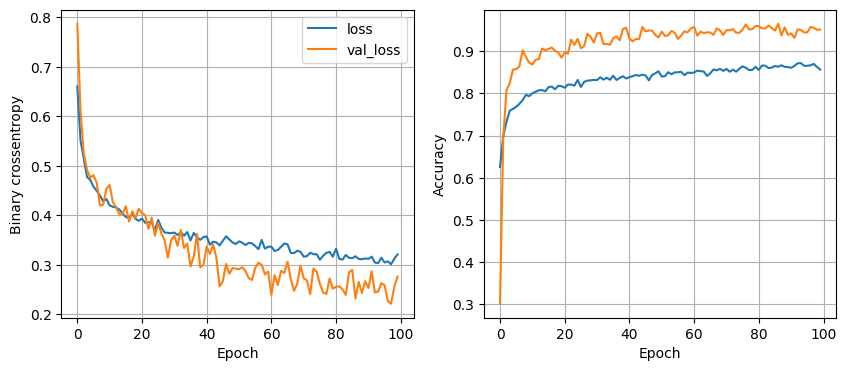

128/128 [==============================] - 0s 1ms/step - loss: 0.2531 - accuracy: 0.8642
32 nodes, dropout 0.2, learning rate0.001, batch size64


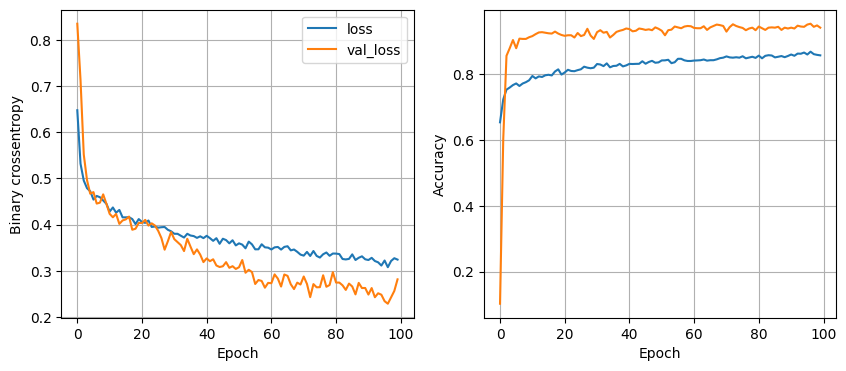

128/128 [==============================] - 0s 1ms/step - loss: 0.2748 - accuracy: 0.8493
32 nodes, dropout 0.2, learning rate0.001, batch size128


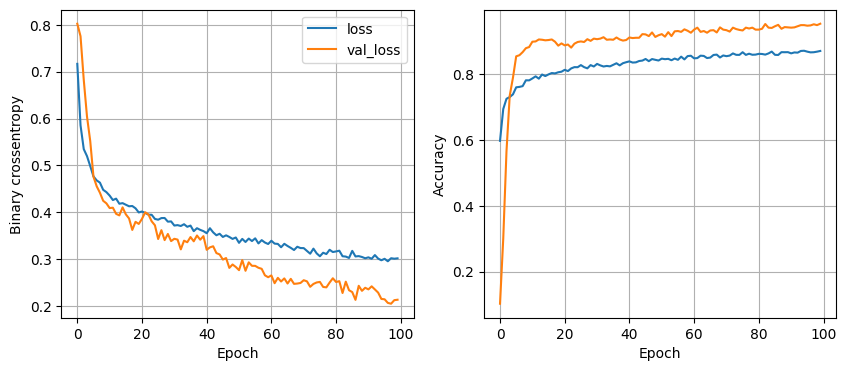

128/128 [==============================] - 0s 1ms/step - loss: 0.3024 - accuracy: 0.8500
32 nodes, dropout 0.2, learning rate0.01, batch size32


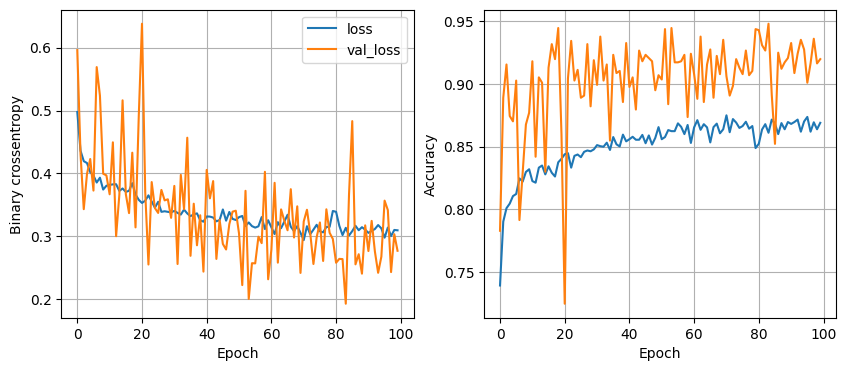

128/128 [==============================] - 0s 1ms/step - loss: 0.2513 - accuracy: 0.8767
32 nodes, dropout 0.2, learning rate0.01, batch size64


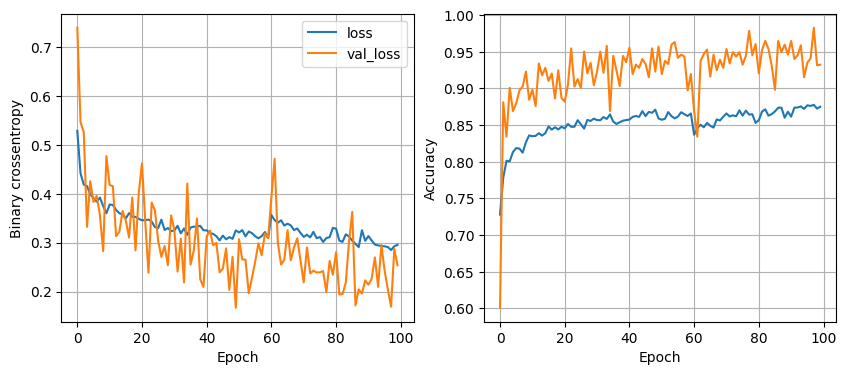

128/128 [==============================] - 0s 1ms/step - loss: 0.2285 - accuracy: 0.8899
32 nodes, dropout 0.2, learning rate0.01, batch size128


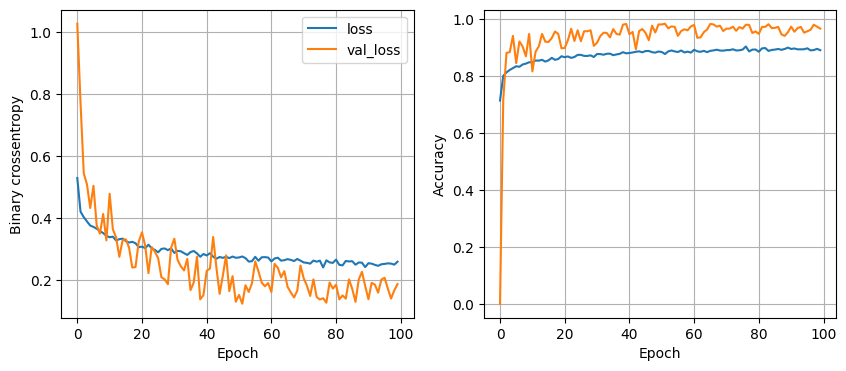

128/128 [==============================] - 0s 1ms/step - loss: 0.2377 - accuracy: 0.8902
64 nodes, dropout 0, learning rate0.005, batch size32


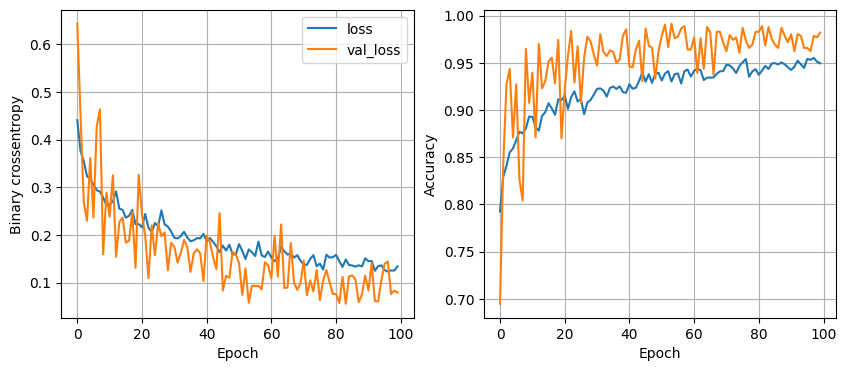

128/128 [==============================] - 0s 1ms/step - loss: 0.1915 - accuracy: 0.9364
64 nodes, dropout 0, learning rate0.005, batch size64


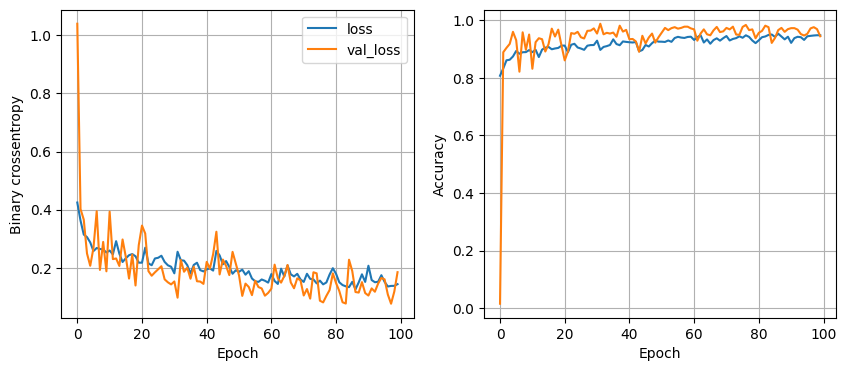

128/128 [==============================] - 0s 1ms/step - loss: 0.1558 - accuracy: 0.9535
64 nodes, dropout 0, learning rate0.005, batch size128


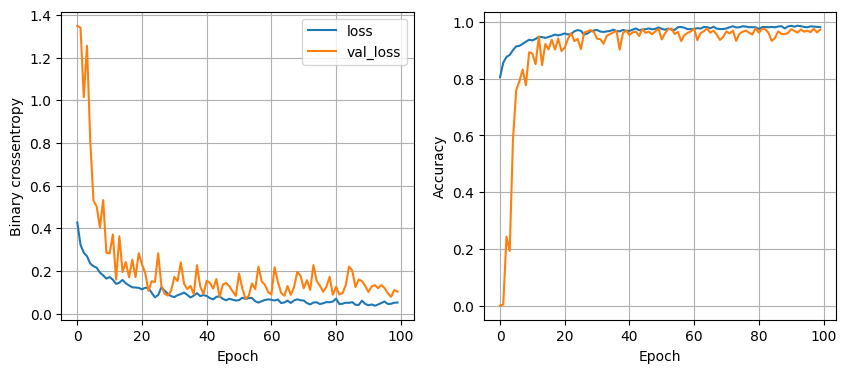

128/128 [==============================] - 0s 1ms/step - loss: 0.1801 - accuracy: 0.9677
64 nodes, dropout 0, learning rate0.001, batch size32


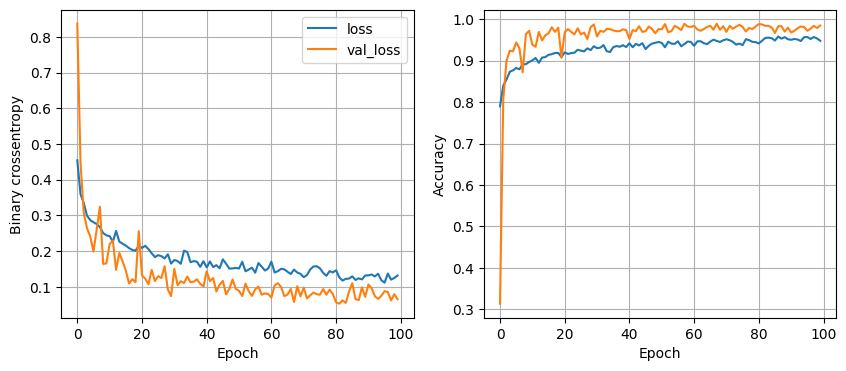

128/128 [==============================] - 0s 1ms/step - loss: 0.1627 - accuracy: 0.9503
64 nodes, dropout 0, learning rate0.001, batch size64


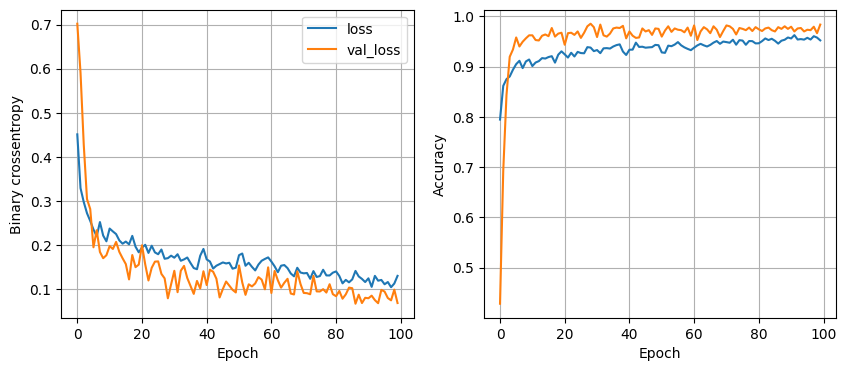

128/128 [==============================] - 0s 1ms/step - loss: 0.1672 - accuracy: 0.9513
64 nodes, dropout 0, learning rate0.001, batch size128


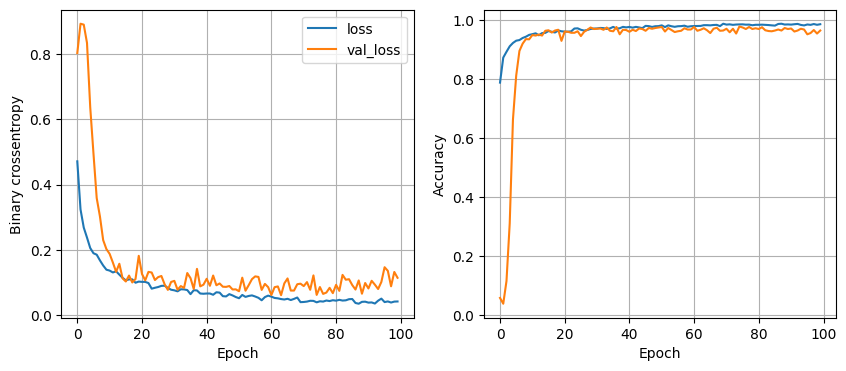

128/128 [==============================] - 0s 1ms/step - loss: 0.1627 - accuracy: 0.9702
64 nodes, dropout 0, learning rate0.01, batch size32


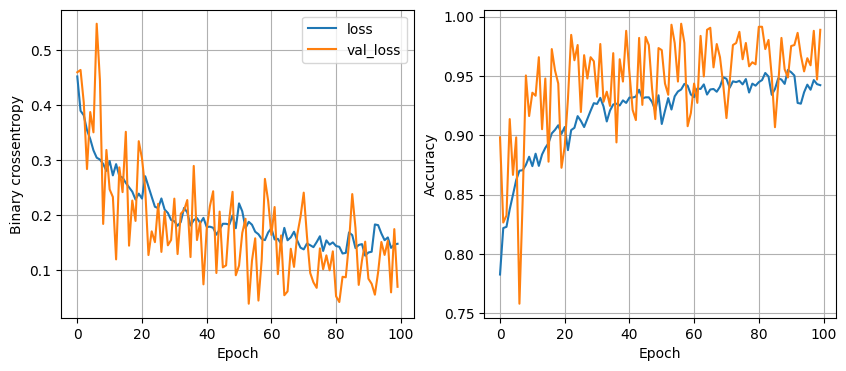

128/128 [==============================] - 0s 1ms/step - loss: 0.2079 - accuracy: 0.9318
64 nodes, dropout 0, learning rate0.01, batch size64


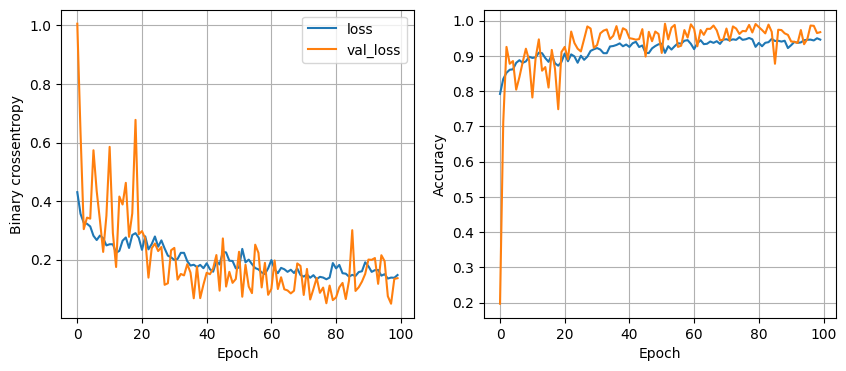

128/128 [==============================] - 0s 1ms/step - loss: 0.1560 - accuracy: 0.9528
64 nodes, dropout 0, learning rate0.01, batch size128


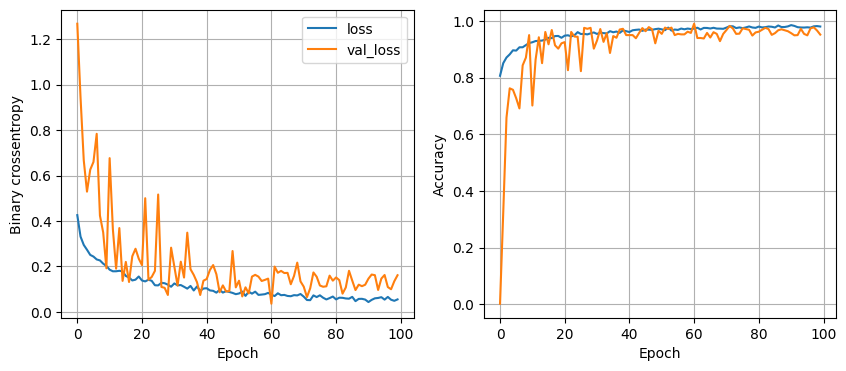

128/128 [==============================] - 0s 1ms/step - loss: 0.1506 - accuracy: 0.9694
64 nodes, dropout 0.2, learning rate0.005, batch size32


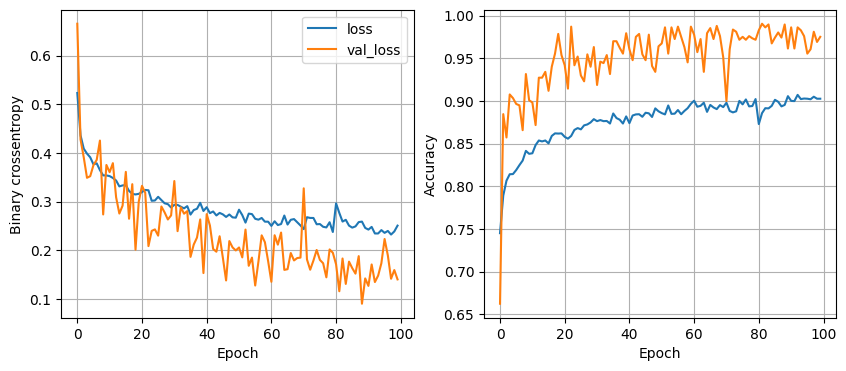

128/128 [==============================] - 0s 1ms/step - loss: 0.2573 - accuracy: 0.8877
64 nodes, dropout 0.2, learning rate0.005, batch size64


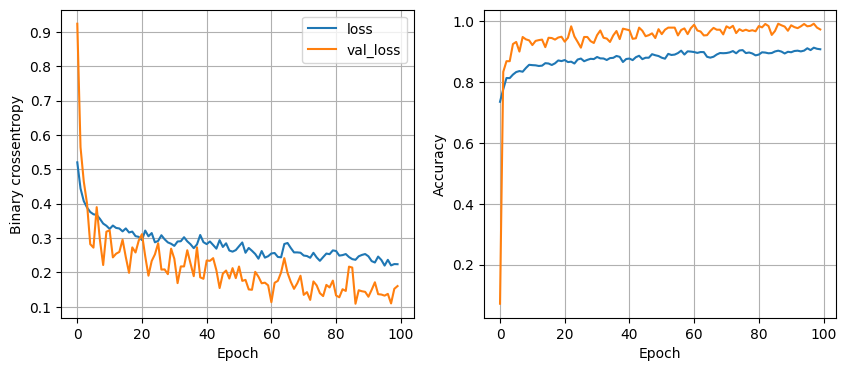

128/128 [==============================] - 0s 1ms/step - loss: 0.1858 - accuracy: 0.9205
64 nodes, dropout 0.2, learning rate0.005, batch size128


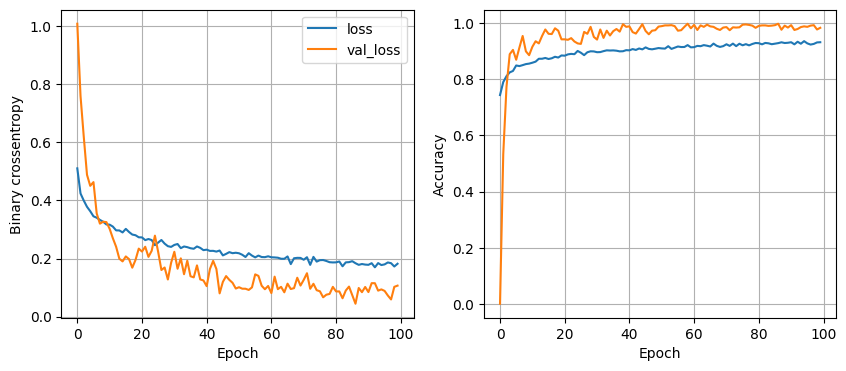

128/128 [==============================] - 0s 1ms/step - loss: 0.1807 - accuracy: 0.9276
64 nodes, dropout 0.2, learning rate0.001, batch size32


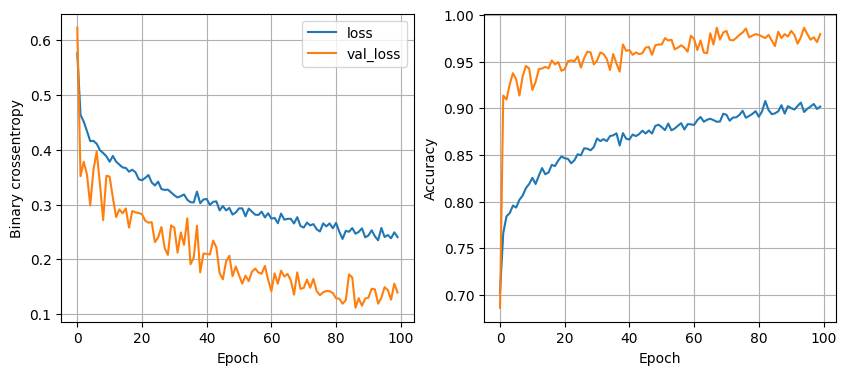

128/128 [==============================] - 0s 1ms/step - loss: 0.2155 - accuracy: 0.9034
64 nodes, dropout 0.2, learning rate0.001, batch size64


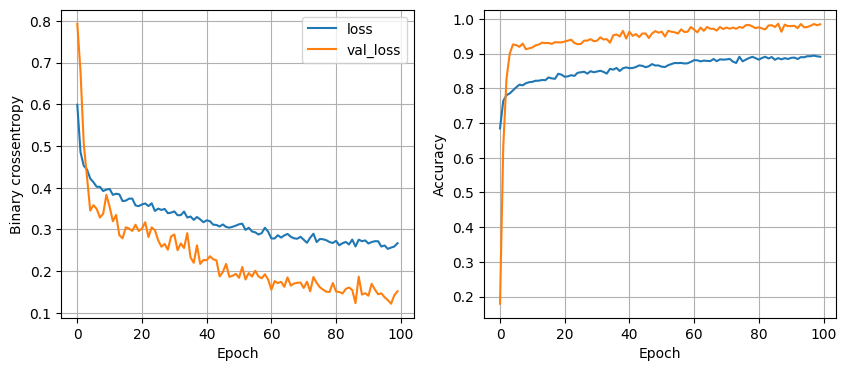

128/128 [==============================] - 0s 1ms/step - loss: 0.2386 - accuracy: 0.8877
64 nodes, dropout 0.2, learning rate0.001, batch size128


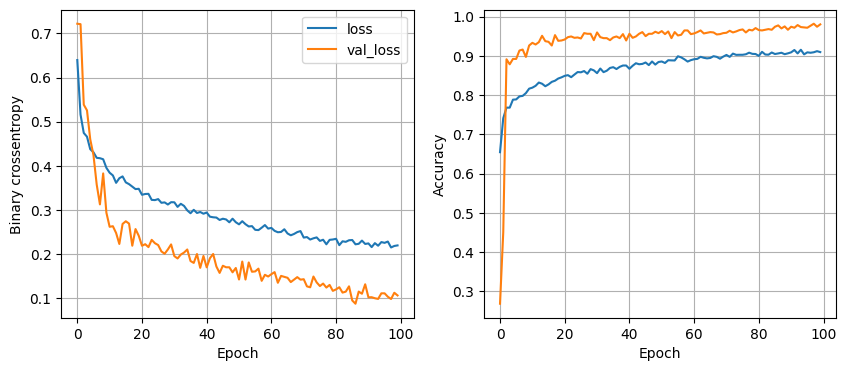

128/128 [==============================] - 0s 1ms/step - loss: 0.2371 - accuracy: 0.9014
64 nodes, dropout 0.2, learning rate0.01, batch size32


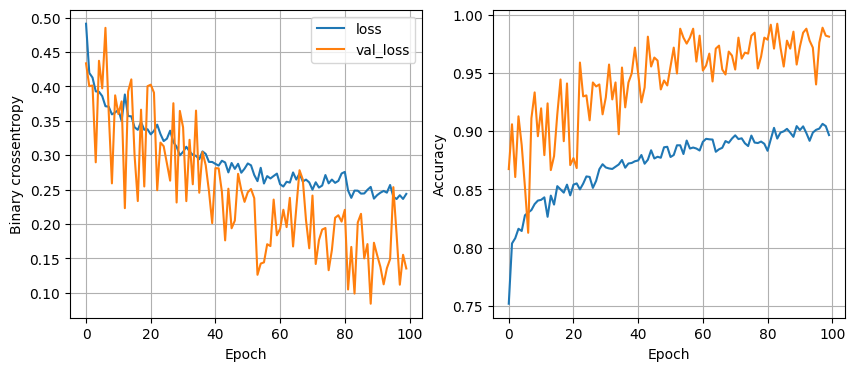

128/128 [==============================] - 0s 1ms/step - loss: 0.2416 - accuracy: 0.8907
64 nodes, dropout 0.2, learning rate0.01, batch size64


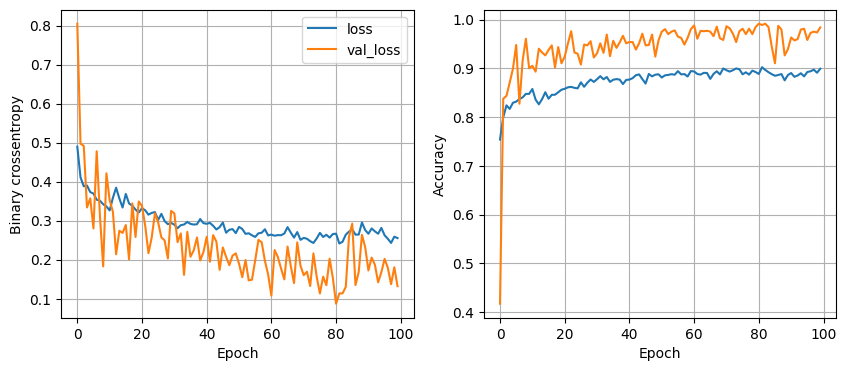

128/128 [==============================] - 0s 1ms/step - loss: 0.2559 - accuracy: 0.8811
64 nodes, dropout 0.2, learning rate0.01, batch size128


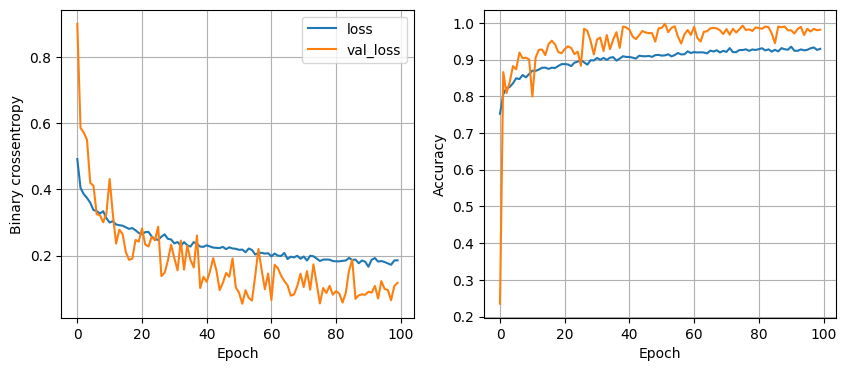

128/128 [==============================] - 0s 1ms/step - loss: 0.1850 - accuracy: 0.9286


In [31]:
least_val_loss = float('inf')
least_loss_model = None
epochs = 100
for num_nodes in [16, 32, 64]:
    for dropout_prob in [0, 0.2]:
        for learning_rate in [0.005,0.001,0.01]:
            for batch_size in [32,64,128]:
                print(f"{num_nodes} nodes, dropout {dropout_prob}, learning rate{learning_rate}, batch size{batch_size}")
                model,history = train_model(X_train_resampled, y_train_resampled, num_nodes, dropout_prob, learning_rate, batch_size, epochs)
                plot_history(history)
                val_loss = model.evaluate(X_train_val,y_train_val)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model

In [32]:
print(model.summary())

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_318 (Dense)           (None, 64)                704       
                                                                 
 batch_normalization_265 (Ba  (None, 64)               256       
 tchNormalization)                                               
                                                                 
 dropout_212 (Dropout)       (None, 64)                0         
                                                                 
 dense_319 (Dense)           (None, 64)                4160      
                                                                 
 batch_normalization_266 (Ba  (None, 64)               256       
 tchNormalization)                                               
                                                                 
 dropout_213 (Dropout)       (None, 64)              

In [33]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
y_pred

32/32 [==============================] - 0s 1ms/step


array([0, 0, 0, ..., 0, 0, 1])

In [34]:
print(classification_report(y_test, y_pred, zero_division=0)) 

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       960
           1       0.09      0.10      0.09        62

    accuracy                           0.89      1022
   macro avg       0.52      0.52      0.52      1022
weighted avg       0.89      0.89      0.89      1022

